# Model

In [84]:
%matplotlib inline
import pandas as pd
import pysd

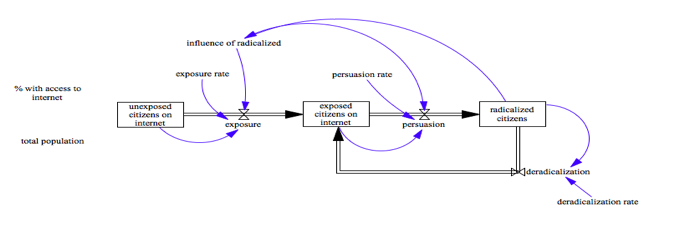

In [85]:
from IPython.display import Image
Image(filename='Radicalization.png')

In [165]:
PySD_model = pysd.read_vensim('ASD_V2.mdl')

def RunASDModel(persuasion_rate=0.05, deradicalization_rate=0.02):
    SD_result = PySD_model.run(params={
                            'persuasion rate':persuasion_rate,
                            'deradicalization rate':deradicalization_rate
                                       })
    time = SD_result.index.values
    return SD_result['radicalized citizens']

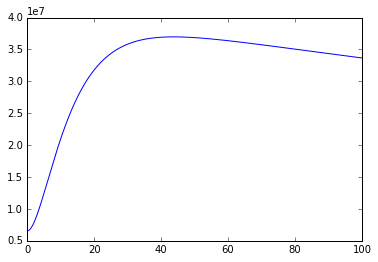

In [170]:
result = RunASDModel(0.05, 0.002)
result.plot()

In [171]:
worldbank_data = pd.read_csv('Internet_data.csv', sep=',' ) # , index_col=0)

In [172]:
worldbank_data.columns

Index(['﻿Series Name', 'Series Code', 'Country Name', 'Country Code',
       '2015 [YR2015]'],
      dtype='object')

In [173]:
# worldbank_data['Series Name']

# Load In Data

In [174]:
# only if the previous cell did not work, try this:

worldbank_data['\ufeffSeries Name'] 

worldbank_data.rename(columns={'\ufeffSeries Name':'Series Name'},inplace=True)

In [175]:
# all internet users per country by World Bank

internet_users_data = worldbank_data[worldbank_data['Series Name'].notnull() & (worldbank_data['Series Name']=='Internet users (per 100 people)') ]
internet_users_data.head()

,Series Name,Series Code,Country Name,Country Code,2015 [YR2015]
2376,Internet users (per 100 people),IT.NET.USER.P2,India,IND,26
2377,Internet users (per 100 people),IT.NET.USER.P2,Bangladesh,BGD,14.4
2378,Internet users (per 100 people),IT.NET.USER.P2,Pakistan,PAK,18
2379,Internet users (per 100 people),IT.NET.USER.P2,Mexico,MEX,57.4310429923633
2380,Internet users (per 100 people),IT.NET.USER.P2,Vietnam,VNM,52.720000000055


In [176]:
internet_users = pd.DataFrame(internet_users_data.ix[:,2:])
internet_users.rename(columns={'2015 [YR2015]':'Percentage Internet Users'},inplace=True)
internet_users.head()

,Country Name,Country Code,Percentage Internet Users
2376,India,IND,26
2377,Bangladesh,BGD,14.4
2378,Pakistan,PAK,18
2379,Mexico,MEX,57.4310429923633
2380,Vietnam,VNM,52.720000000055


In [177]:
# total population per country by World Bank
# http://databank.worldbank.org/data/reports.aspx?Code=IT.NET.USER.P2&id=af3ce82b&report_name=Popular_indicators&populartype=series&ispopular=y

population_data = worldbank_data[worldbank_data['Series Code'].notnull() & (worldbank_data['Series Code']=='SP.POP.TOTL') ]
population_data.head()

,Series Name,Series Code,Country Name,Country Code,2015 [YR2015]
4488,"Population, total",SP.POP.TOTL,India,IND,1311050527
4489,"Population, total",SP.POP.TOTL,Bangladesh,BGD,160995642
4490,"Population, total",SP.POP.TOTL,Pakistan,PAK,188924874
4491,"Population, total",SP.POP.TOTL,Mexico,MEX,127017224
4492,"Population, total",SP.POP.TOTL,Vietnam,VNM,91703800


In [178]:
population = pd.DataFrame(population_data.ix[:,2:])
population.rename(columns={'2015 [YR2015]':'Total Population'},inplace=True)
population.head()

,Country Name,Country Code,Total Population
4488,India,IND,1311050527
4489,Bangladesh,BGD,160995642
4490,Pakistan,PAK,188924874
4491,Mexico,MEX,127017224
4492,Vietnam,VNM,91703800


In [179]:
# total number of foreign fighters per country
# sources:
# https://www.icct.nl/wp-content/uploads/2016/03/ICCT-Report_Foreign-Fighters-Phenomenon-in-the-EU_1-April-2016_including-AnnexesLinks.pdf
#Foreign Fighters In Iraq & Syria-Where do they come from?， 
#International Centre For The Study Of Radicalisation And Political Violence 2015, New York Times, Associated Press, State Broadcasters
#http://www.rferl.org/a/foreign-fighters-syria-iraq-is-isis-isil-infographic/26584940.html
foreign_fighters = pd.read_csv('Foreign_Fighters.csv',sep=';').ix[:,:2]
foreign_fighters.head()

,Country Name,Foreign_Fighters
0,Albania,90
1,Austria,150
2,Belarus,10
3,Belgium,440
4,Bosnia and Herzegovina,340


In [180]:
# % of total population that is Muslim
# source: https://www.theguardian.com/news/datablog/2011/jan/28/muslim-population-country-projection-2030

percentage_of_muslims = pd.read_csv('MuslimPopulation.csv',sep=';')
percentage_of_muslims.head()

,Country Name,% Muslim
0,Cyprus,22.7
1,Albania,82.1
2,Austria,5.7
3,Belarus,0.2
4,Belgium,6.0


In [181]:
European_countries = ['CHE','GBR','NLD','SWE','DEU','HRV','CYP','CZE','DNK','FIN','NOR',
                      'BEL','BLR','POL','PRT','ESP','FRA','GRC','AUT','ITA','IRL','ICL',
                     'MKD','LUX','LIE','MDA','HUN','UKR','ALB','AND','BHE','EST',
                     'LTU','LVA','FRO','ROU','MLT','SRB','SVK','SVN','BIH','BGR']

i_p_data= internet_users.merge(population,how='inner', on=['Country Code','Country Name'])
i_p_Europe = i_p_data[i_p_data['Country Code'].isin (European_countries)]

In [182]:
country_data = i_p_Europe.merge(foreign_fighters,how='inner', on='Country Name').merge(percentage_of_muslims,how='inner',on='Country Name')
country_data.head(1)

,Country Name,Country Code,Percentage Internet Users,Total Population,Foreign_Fighters,% Muslim
0,Albania,ALB,63.252932696931,2889167,90,82.1


# Run Model

In [185]:
def RunASDModel(row):
    SD_result = PySD_model.run(params={
                            "percent with access to internet": float(row['Percentage Internet Users']) /100,
                            "total population": int(row['Total Population']),
                             "percent of muslims in population": float(row[r'% Muslim']) /100,
                            "number of foreign fighters":int(row['Foreign_Fighters'])
                                       })
    time = SD_result.index.values
    return SD_result['radicalized citizens']

In [186]:
# only with the European countries

sim_results = country_data.apply(RunASDModel,axis=1)

In [187]:
sim_results

,0.0,0.0625,0.125,0.1875,0.25,0.3125,0.375,0.4375,0.5,0.5625,...,99.4375,99.5,99.5625,99.625,99.6875,99.75,99.8125,99.875,99.9375,100.0
0,14445.835,14445.835,14454.748851,14472.381407,14498.540911,14533.038948,14575.690381,14626.313308,14684.729000,14750.761854,...,9.076733e+04,9.075576e+04,9.074420e+04,9.073264e+04,9.072108e+04,9.070952e+04,9.069796e+04,9.068640e+04,9.067484e+04,9.066329e+04
1,43055.440,43055.440,43090.699897,43160.447912,43263.925686,43400.388054,43569.102836,43769.350626,44000.424580,44261.630215,...,3.471754e+05,3.471312e+05,3.470870e+05,3.470428e+05,3.469986e+05,3.469543e+05,3.469101e+05,3.468659e+05,3.468218e+05,3.467776e+05
2,47565.000,47565.000,47593.875157,47650.993312,47735.733293,47847.484741,47985.647932,48149.633602,48338.862783,48552.766629,...,2.946763e+05,2.946388e+05,2.946012e+05,2.945637e+05,2.945262e+05,2.944886e+05,2.944511e+05,2.944136e+05,2.943761e+05,2.943386e+05
3,56428.605,56428.605,56475.437564,56568.077618,56705.517907,56886.768703,57110.857527,57376.828861,57683.743876,58030.680161,...,4.604834e+05,4.604248e+05,4.603661e+05,4.603075e+05,4.602489e+05,4.601902e+05,4.601316e+05,4.600730e+05,4.600143e+05,4.599557e+05
4,35889.955,35889.955,35909.788978,35949.022678,36007.229389,36083.989831,36178.892028,36291.531191,36421.509602,36568.436496,...,2.051203e+05,2.050942e+05,2.050681e+05,2.050419e+05,2.050158e+05,2.049897e+05,2.049635e+05,2.049374e+05,2.049113e+05,2.048852e+05
5,21122.020,21122.020,21136.404515,21164.858655,21207.073002,21262.743527,21331.571494,21413.263381,21507.530792,21614.090375,...,1.446291e+05,1.446107e+05,1.445923e+05,1.445739e+05,1.445554e+05,1.445370e+05,1.445186e+05,1.445002e+05,1.444818e+05,1.444634e+05
6,5826.500,5826.500,5830.576799,5838.641155,5850.605375,5866.383294,5885.890247,5909.043047,5935.759959,5965.960679,...,4.085556e+04,4.085036e+04,4.084515e+04,4.083995e+04,4.083475e+04,4.082954e+04,4.082434e+04,4.081914e+04,4.081394e+04,4.080874e+04
7,52756.095,52756.095,52797.945387,52880.730110,53003.549045,53165.517731,53365.767119,53603.443318,53877.707352,54187.734916,...,4.134591e+05,4.134065e+05,4.133538e+05,4.133011e+05,4.132485e+05,4.131958e+05,4.131432e+05,4.130906e+05,4.130379e+05,4.129853e+05
8,28380.010,28380.010,28406.689380,28459.464222,28537.760755,28641.015196,28768.673585,28920.191624,29095.034521,29292.676836,...,2.591539e+05,2.591209e+05,2.590879e+05,2.590549e+05,2.590219e+05,2.589889e+05,2.589559e+05,2.589229e+05,2.588899e+05,2.588569e+05
9,6559.990,6559.990,6565.649268,6576.843937,6593.452293,6615.354738,6642.433761,6674.573898,6711.661705,6753.585719,...,5.542696e+04,5.541990e+04,5.541284e+04,5.540579e+04,5.539873e+04,5.539167e+04,5.538461e+04,5.537756e+04,5.537050e+04,5.536345e+04


In [189]:
country_results = pd.concat([country_data,sim_results], axis=1)  
country_results.head()

,Country Name,Country Code,Percentage Internet Users,Total Population,Foreign_Fighters,% Muslim,0.0,0.0625,0.125,0.1875,...,99.4375,99.5,99.5625,99.625,99.6875,99.75,99.8125,99.875,99.9375,100.0
0,Albania,ALB,63.252932696931,2889167,90,82.1,14445.835,14445.835,14454.748851,14472.381407,...,90767.325642,90755.761577,90744.198602,90732.636720,90721.075932,90709.516240,90697.957647,90686.400154,90674.843764,90663.288479
1,Austria,AUT,83.9263,8611088,150,5.7,43055.440,43055.440,43090.699897,43160.447912,...,347175.420233,347131.197191,347086.978270,347042.763477,346998.552822,346954.346311,346910.143955,346865.945760,346821.751736,346777.561890
2,Belarus,BLR,62.230360906803,9513000,10,0.2,47565.000,47565.000,47593.875157,47650.993312,...,294676.315200,294638.771987,294601.232315,294563.696192,294526.163624,294488.634618,294451.109182,294413.587320,294376.069042,294338.554352
3,Belgium,BEL,85.0529,11285721,440,6.0,56428.605,56428.605,56475.437564,56568.077618,...,460483.441891,460424.786188,460366.135948,460307.491180,460248.851897,460190.218110,460131.589830,460072.967067,460014.349833,459955.738138
4,Bulgaria,BGR,56.6563,7177991,7,13.4,35889.955,35889.955,35909.788978,35949.022678,...,205120.322331,205094.187104,205068.054354,205041.924084,205015.796301,204989.671008,204963.548210,204937.427913,204911.310119,204885.194835


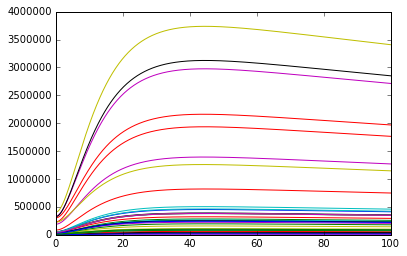

In [190]:
sim_results_transposed = pd.DataFrame(sim_results).T
sim_results_transposed.plot(legend=False)

# Geospatial

In [191]:
import geopandas as gp

In [192]:
shapefile = r'preprocessed_data/geo_df_EU.shp'
geo_data = gp.GeoDataFrame.from_file(shapefile).ix[:,0:2]
geo_data.head(5)

,country,geometry
0,Albania,"POLYGON ((20.59024743010491 41.85540416113361,..."
1,Austria,"POLYGON ((16.97966678230404 48.12349701597631,..."
2,Belgium,"POLYGON ((3.314971144228537 51.34578095153609,..."
3,Bulgaria,"POLYGON ((22.65714969248299 44.23492300066128,..."
4,Bosnia and Herzegovina,"POLYGON ((19.00548628101012 44.86023366960916,..."


In [193]:
geo_data_merged = pd.merge(country_results, geo_data,left_on='Country Name',right_on='country')
geo_data_merged.head()

,Country Name,Country Code,Percentage Internet Users,Total Population,Foreign_Fighters,% Muslim,0.0,0.0625,0.125,0.1875,...,99.5625,99.625,99.6875,99.75,99.8125,99.875,99.9375,100.0,country,geometry
0,Albania,ALB,63.252932696931,2889167,90,82.1,14445.835,14445.835,14454.748851,14472.381407,...,90744.198602,90732.636720,90721.075932,90709.516240,90697.957647,90686.400154,90674.843764,90663.288479,Albania,"POLYGON ((20.59024743010491 41.85540416113361,..."
1,Austria,AUT,83.9263,8611088,150,5.7,43055.440,43055.440,43090.699897,43160.447912,...,347086.978270,347042.763477,346998.552822,346954.346311,346910.143955,346865.945760,346821.751736,346777.561890,Austria,"POLYGON ((16.97966678230404 48.12349701597631,..."
2,Belarus,BLR,62.230360906803,9513000,10,0.2,47565.000,47565.000,47593.875157,47650.993312,...,294601.232315,294563.696192,294526.163624,294488.634618,294451.109182,294413.587320,294376.069042,294338.554352,Belarus,"POLYGON ((23.48412763844985 53.91249766704114,..."
3,Belgium,BEL,85.0529,11285721,440,6.0,56428.605,56428.605,56475.437564,56568.077618,...,460366.135948,460307.491180,460248.851897,460190.218110,460131.589830,460072.967067,460014.349833,459955.738138,Belgium,"POLYGON ((3.314971144228537 51.34578095153609,..."
4,Bulgaria,BGR,56.6563,7177991,7,13.4,35889.955,35889.955,35909.788978,35949.022678,...,205068.054354,205041.924084,205015.796301,204989.671008,204963.548210,204937.427913,204911.310119,204885.194835,Bulgaria,"POLYGON ((22.65714969248299 44.23492300066128,..."


In [194]:
converted_geo_data=gp.GeoDataFrame (geo_data_merged)

In [195]:
import matplotlib.pyplot as plt

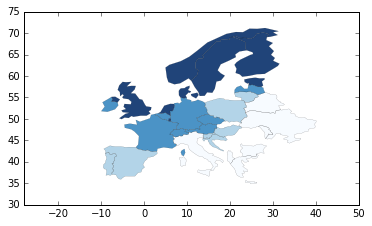

In [196]:
converted_geo_data.plot(column='Percentage Internet Users', scheme='fisher_jenks', alpha=0.9, k=4, linewidth=0.1,
             cmap=plt.cm.Blues, legend=False)
plt.xlim([-28, 50])
plt.ylim([30, 75])
plt.show()

In [197]:
import matplotlib as mpl
from ipywidgets import interact, FloatSlider, IntSlider,RadioButtons, Dropdown
sim_time = 100
slider_time = IntSlider(description = 'Time Select',
                        min=0, max=sim_time-1, value=1)

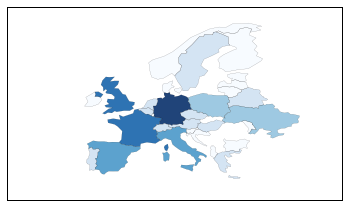

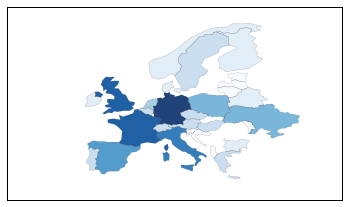

In [199]:
@interact( time = slider_time) # Scenario = select_scenario,
def update_map(time): # Scenario
    ax = converted_geo_data.plot(column=time, scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1,
             cmap=plt.cm.Blues, legend=False)
    plt.xlim(-28, 50)
    plt.ylim(30, 75)
    plt.xticks([])
    plt.yticks([])